# Tensorflow and Deep Learning with MNIST Data

## Traditional Neural Networks

Notes from lecture by Martin Gorner here: https://www.youtube.com/watch?v=vq2nnJ4g6N0

And there's a Google self-paced lab here: https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist

### TensorFlow - Initialization

In [1]:
import tensorflow as tf

# code here was written, but full code is here:
# https://github.com/martin-gorner/tensorflow-mnist-tutorial/blob/master/mnist_1.0_softmax.py

# this will download the code for you, should put something in here to pickle it
# when first downloaded, then check for pickle file and load that instead

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=False, validation_size=0)

X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# datatype, 
# None = unknown batch size (will become 100)
# dimensions of an image (28x28)
# and number of values per pixel (1) - could use 3 for RGB

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
# training = computing variables W and b


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### TensorFlow - Model

In [2]:
# model
# the -1 in tf.reshape means "there's only one solution, TensorFlow, go figure it out!"
# the -1 will end up being the number of images in the batch, basically the -1 means
# to keep the number of samples the same
Y = tf.nn.softmax(tf.matmul(tf.reshape(X, [-1, 784]), W) + b)

# placeholder for correct answers
Y_ = tf.placeholder(tf.float32, [None, 10])

# loss function
cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y))

is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

### TensorFlow - Training

GradientDescentOptimizer is the simplest optimizer in the library.

In [3]:
learn_rate = 0.003
optimizer = tf.train.GradientDescentOptimizer(learn_rate)
train_step = optimizer.minimize(cross_entropy)

Cross-entropy depends on:

* Training images
* Training labels
* Weights
* Biases


First, compute gradient - “formal derivation”

* Gradient - vector of all the partial derivatives of this function, relative to all weights and biases in the system
* 784 x 10 weights
* Think of the learning rate as a little fraction of the gradient you’ll be adding to weights and biases at each step
* NOTE:  all the TensorFlow stuff is deferred execution - statements don’t produce results but just define a computation graph in memory


### TensorFlow - Run

In [4]:
# init = tf.initialize_all_variables() # DEPRECATED
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

training_steps = 100000
batch_size = 100

batch_X, batch_Y = mnist.train.next_batch(batch_size)
train_data = {X: batch_X, Y_: batch_Y}


Why are we running these batches (`batch_size`) 100 at a time?    Two reasons:

1. We want to be running this on GPUs, with minibatching you use bigger matrices, bigger matrices are easier to optimize on GPUs
1. If you compute the gradient on one image, from one image to the nsxt, there can be a little variation on where the gradient points.  With 100 at a time, it's a little more stable, as you get a consensus over 100 images.

In [5]:
sess = tf.Session()
sess.run(init)

training_steps = 10000
batch_size = 100

train_accuracy = []
train_xent = []
test_accuracy = []
test_xent = []

for i in range(training_steps):
    # load batch of images and labels
    batch_X, batch_Y = mnist.train.next_batch(batch_size)
    train_data = {X: batch_X, Y_: batch_Y}

    # train (here, we’re running a TensorFlow computation, feeding placeholders
    sess.run(train_step, feed_dict=train_data)

    # TIP - do the “success” parts every 100 iterations
    if i % 100 == 0:
        # success?
        a, c = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        train_accuracy.append(a)
        train_xent.append(c)
        
        # success on test data?
        test_data = {X: mnist.test.images, Y_ : mnist.test.labels}
        a, c = sess.run([accuracy, cross_entropy], feed_dict = test_data)
        
        test_accuracy.append(a)
        test_xent.append(c)

### Static Visualizations

In [6]:
import matplotlib.pyplot as plt

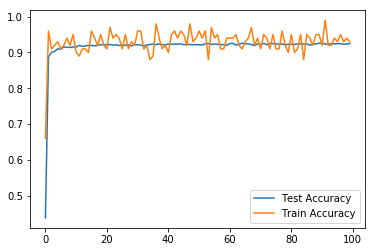

In [7]:
plt.plot(range(len(test_accuracy)), test_accuracy, label="Test Accuracy")
plt.plot(range(len(train_accuracy)), train_accuracy, label="Train Accuracy")
plt.legend()
plt.show()

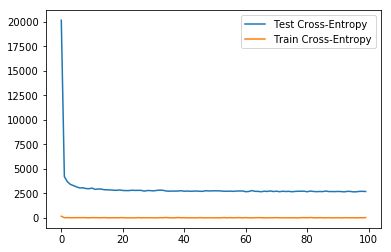

In [8]:
import math
plt.plot(range(len(test_xent)), test_xent, label="Test Cross-Entropy")
plt.plot(range(len(train_xent)), train_xent, label="Train Cross-Entropy")
plt.legend()
plt.show()

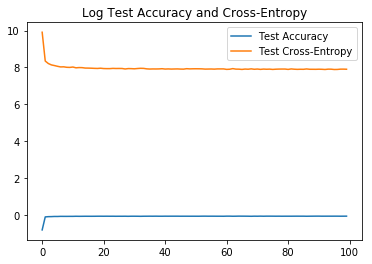

In [9]:
plt.plot(range(len(test_accuracy)), [math.log(x) for x in test_accuracy], label="Test Accuracy")
plt.plot(range(len(test_xent)), [math.log(x) for x in test_xent], label="Test Cross-Entropy")

plt.title("Log Test Accuracy and Cross-Entropy")
plt.legend()
plt.show()

An accuracy of ~92% isn't very good though!  We can remedy this by adding layers to our network.  This can be done relatively easily in TensorFlow.

First, each layer will require its own weights matrix, and its own bias vector.

Also, good practice to use `tf.truncated_normal()` to initialize weights matrices.

Essentially what we'll be doing is feeding each hidden layer with the outputs of the previous layer, and using the `tf.nn.relu()` function as the activation function for all layers with the exception of the output layer.

While our original model was this:

`Y = tf.nn.softmax(tf.matmul(tf.reshape(X, [-1, 784]), W) + b)`

Our new model will look like this:

`X = tf.reshape(X, [-1, 28*28])             # 28*28 = 784
Y1 = tf.nn.relu(tf.matmul(X, W1) + b1)
Y2 = tf.nn.relu(tf.matmul(Y1, W2) + b2)
Y3 = tf.nn.relu(tf.matmul(Y2, W3) + b3)
Y4 = tf.nn.relu(tf.matmul(Y3, W4) + b4)
Y = tf.nn.softmax(tf.matmul(Y4, W5 + b5)`

In [10]:
# dimensions of various layers
K = 100
L = 200
M = 60
N = 30
n_output_classes = 10


# initialize weights and biases
W1 = tf.truncated_normal([28*28, K], stddev=0.1)
b1 = tf.zeros([K])
W2 = tf.truncated_normal([K, L], stddev=0.1)
b2 = tf.zeros([L])
W3 = tf.truncated_normal([L, M], stddev=0.1)
b3 = tf.zeros([M])
W4 = tf.truncated_normal([M, N], stddev=0.1)
b4 = tf.zeros([N])
W5 = tf.truncated_normal([N, n_output_classes], stddev=0.1)
b5 = tf.zeros([n_output_classes])

# new model looks like this
X = tf.reshape(X, [-1, 28*28])
Y1 = tf.nn.relu(tf.matmul(X, W1) + b1)
Y2 = tf.nn.relu(tf.matmul(Y1, W2) + b2)
Y3 = tf.nn.relu(tf.matmul(Y2, W3) + b3)
Y4 = tf.nn.relu(tf.matmul(Y3, W4) + b4)
Y = tf.nn.softmax(tf.matmul(Y4, W5) + b5)

Note that we're using `tf.nn.relu()` ([RELU = Rectified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) as our activation function for non-output layers, instead of the `tf.nn.sigmoid()` function.  This is due to the fact that the sigmoid function is flat at the ends (see image comparing RELU and sigmoid below), so its gradient is zero.  A gradient of zero is particularly problematic in deep neural networks.  A RELU returns 0 for anything below zero, and it's the identity function for anything above zero.  See the images below for illustrations of these different activation functions.

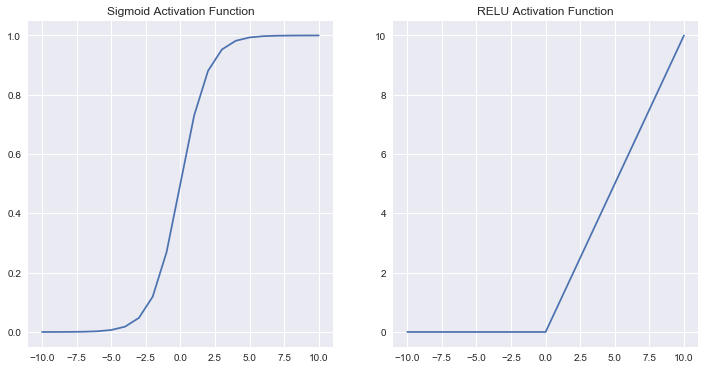

In [11]:
# 1 / (1 + e^-x)
import numpy as np
import seaborn
from __future__ import division
sigmoid = lambda x: 1 / (1 + np.exp(-x))

plt.clf()
fig = plt.figure()
left = fig.add_subplot(1, 2, 1)
right = fig.add_subplot(1, 2, 2)


sig_points = [(x, sigmoid(x)) for x in range(-10,11)]

left.plot([x[0] for x in sig_points], [y[1] for y in sig_points])
left.set_title("Sigmoid Activation Function")

relu = lambda x: x if x >=0 else 0
relu_points = [(x, relu(x)) for x in range(-10,11)]

right.plot([x[0] for x in relu_points], [y[1] for y in relu_points])
right.set_title("RELU Activation Function")
fig.set_size_inches((12, 6))

# fig.set_tight_layout(True)
fig

If you see the test accuracy and test cross-entropy jump around a lot, it usually means we're going too fast... like "jumping from one side of the valley to another."  There are two ways to address this:

1. **Reduce the learning rate** - if you reduce your learning rate by a factor of 10, for example, you'll slow down, but also slow your training by a factor of 10, so this isn't desirable.
2. **Learning rate decay** - start learning fast and then slowly decay your learning rate to slow down toward the end.  So for instance, start at 0.003, and then drop exponentially to 0.0001.

With a data set of 60,000 and a batch size of 100, an epoch would consist of 60,000 / 100 = 600 training runs.  

An *epoch* is when you've seen all of your training data once.  So an epoch in this case would consist of 600 iterations of training data.


### Dropout

If your test cross-entropy loss goes down, but then starts to go back up, you may be overfitting the training data.  You may need to apply regularization in this case.

Dropout means you give each neuron a percentage chance of remaining in the network.  So after each iteration, you'll remove x% of the neurons from your network for that **layer**.  You add dropout after the activation function of each hidden layer (except the inputs and outputs).

In [ ]:
pkeep = tf.placeholder(tf.float32)  # e.g., 0.75 means each neuron has a 75% chance of remaining in the network
Yf = tf.nn.relu(tf.matmul(X, W) + b)
Y = tf.nn.dropout(X, pkeep)

What this does in effect is sets the weights and biases to 0 for the "dropout" neurons.  It also slightly boosts the weights for the remaining neurons so the average across the network is not affected.

When you're testing, you use 100% of the neurons in the network, so you'd set the `pkeep` placeholder to 1.

Dropout **does** bring some noise back in, but that's to be expected, as it's a "brutal technique."

Overfitting in a neural network happens when you have too many degrees of freedom (weights and biases).  What essentially happens is that the NN memorizes the data.  Always need lots of data to train a NN, but remember, it's a tradeoff.

So we're stuck at 98% accuracy with this model, we can't get any better.  Why?  Because we flattened all of our images into vectors of 28 x 28 = 784-item vectors.  Images have 2D data that's important in their representation, therefore, convolutional neural networks can be used to improve accuracy.

## Convolutional Neural Networks

[Link to video starting at this point in the lecture](https://www.youtube.com/watch?v=vq2nnJ4g6N0&feature=youtu.be&t=3580)

Remember before how we told our X matrix it was going to have a single value per pixel because the images were in grayscale?  Now is the time we would change that value to `3` to signify three values per pixel.  This would represent RGB values for color images:

In [ ]:
X = tf.placeholder(tf.float32, [None, 28, 28, 3])

A convolutional neural network, by comparison, wouldn't have a neuron for every pixel, so there wouldn't be an individual bias and weight for every pixel.  Rather, each neuron would represent a grid (say 4x4) of neurons that would have a set of weights and biases, doing a weighted sum of the batch of inputs.  The grid would then move over one pixel to include 12 of the previous neurons and four new ones, but would use the **same** weights and biases as the previous neuron.

So in effect, we have a 4x4x3 matrix that's scanning the 2D image in both directions using that little batch of weights.  If we do this effectively (include "padding" for pixels on the edge of the image), we'll end up with the same number of outputs as we had pixels in the original image.

So if the patch is `W[4, 4, 3]`, we have 48 weights and 48 biases.  Compared to the nearly 8,000 we had before, we don't have nearly enough degrees of freedom.  If we use two output channels, we end up with:

`W[4, 4, 3, 2]`

Where 4x4 is the shape of the patch  
3 is the number of input channels per pixel (RGB)  
2 is the number of passes, e.g., one for horizontal, one for vertical? **NOTE: need to clarify this**